In [8]:
# colab 전용 라이브러리
from google.colab import files, drive, output

# pytroch download
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

output.clear()

In [6]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import scipy as sp
from torch.autograd import Variable

In [7]:
# linear layer
import torch
from torch.nn import Linear, ReLU
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
myLayer = Linear(in_features = 10 , out_features = 5, bias = True)  # myLayer은 weight을 통해 가중치 전체를 출력 가능, bias를 통해 b 값을 알 수 있다. 

inp = Variable(torch.randn(1,10))
myLayer(inp)

tensor([[ 0.2016, -0.0500,  0.4206, -0.3059, -0.0823]],
       grad_fn=<AddmmBackward>)

In [4]:
myLayer.weight.size()

torch.Size([5, 10])

In [5]:
myRelu = ReLU()
sample_data = Variable(torch.Tensor([1,2,-1,-1]))
myRelu(sample_data)

tensor([1., 2., 0., 0.])

In [6]:
# 신경망
class MyFirstNetwork(nn.Module):
    def __init__(self, input_size, hiddne_size, output_size):
        super(MyFirstNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        out = self.layer1(input)
        out = nn.ReLU(out)
        out = self.layer2(out)
        return out

# loss and optimizer
loss = nn.MSELoss()

inputs = torch.autograd.Variable(torch.randn(3,5), requires_grad = True)
target = torch.autograd.Variable(torch.randn(3,5))

outputs = loss(inputs, target)
outputs.backward()

In [1]:
# image classification 
!pip install kaggle

from google.colab  import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jskimhappyfunc","key":"eeea32ddd7f5d9cc659f2387c6aeee4a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 537M/543M [00:03<00:00, 141MB/s]
100% 543M/543M [00:04<00:00, 141MB/s]
 98% 265M/271M [00:03<00:00, 117MB/s]
100% 271M/271M [00:03<00:00, 88.2MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 90.1MB/s]


In [17]:
!ls

kaggle.json  sample_data  sampleSubmission.csv	test1  test1.zip  train.zip


In [ ]:
!unzip "train.zip"

In [9]:
import glob
import os

path = "./"
fs = glob.glob(os.path.join(path, '*/*.jpg'))

print("Total number of images : {}".format(len(fs)))

no_of_images = len(fs)

shuffle = np.random.permutation(no_of_images)

# 검증 이미지를 저장할 검증용 디렉토리 생성
os.mkdir(os.path.join(path, 'valid'))

# 레이블명으로 디렉토리 생성
for t in ['train', 'valid']:
    for folder in ['dog/', 'cat/']:
        os.mkdir(os.path.join(path, t, folder)) # join : path + t + folder 형태의 string으로 구현된 주소값

# valid folder 내 이미지 복사

for i in shuffle[:2000]:
    folder = fs[i].split('/')[-1].split('.')[0] # 이렇게 하면 dog, cat 형태로 구분
    image = fs[i].split('/')[-1] 
    os.rename(fs[i], os.path.join(path, 'valid', folder, image))

for i in shuffle[2000:]:
    folder = fs[i].split('/')[-1].split('.')[0]
    image = fs[i].split('/')[-1]
    os.rename(fs[i], os.path.join(path, 'train', folder, image))

Total number of images : 25000


In [11]:
# library import 

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
%matplotlib inline

In [10]:
# image show function

def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.299, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0,1)
    plt.imshow(inp)

In [14]:
# gpu 가용 상태 확인
if torch.cuda.is_available():
    is_cuda = True

# 데이터를 pytorch tensor 객체로 로딩
# torchvision에 transforms 라이브러리 존재
# 계층적인 폴더 구조 내에서 데이터셋을 불러올 때 사용한다. 

simple_transform = transforms.Compose([transforms.Scale((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder('./train/', simple_transform)
valid = ImageFolder('./valid/', simple_transform)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


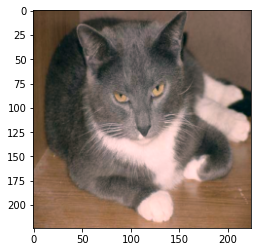

In [16]:
imshow(train[50][0])

In [18]:
train.class_to_idx

{'cat': 0, 'dog': 1}

In [20]:
train.classes

['cat', 'dog']

In [42]:
# dataloader 생성
# num_workers : 멀티스레드 수

train_data_gen = torch.utils.data.DataLoader(train, batch_size = 32, num_workers = 3)
valid_data_gen = torch.utils.data.DataLoader(valid, batch_size = 32, num_workers = 3)

In [43]:
dataset_sizes = {'train':len(train_data_gen.dataset), 'valid':len(valid_data_gen.dataset)}

In [44]:
dataloaders = {'train':train_data_gen, "valid":valid_data_gen}

In [47]:
# torchvision에서 models라는 라이브러리를 참조
# 선학습된 모델을 불러온다. 
# cuda로 인해 캐시메모리에 호출된 데이터를 모두 소거한다. 
torch.cuda.empty_cache()

model_ft = models.resnet18(pretrained = True, progress = True)
num_ftrs = model_ft.fc.in_features # 원래 선학습된 모델이 구분하는 features

model_ft.fc = nn.Linear(num_ftrs, 2) # LInear layout으로 연결하여 2개를 구분하는 이진분류기로 생성

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

# loss and optimizer

lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(model_ft.parameters(), lr = lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

RuntimeError: ignored

In [29]:
# training model
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs = 32):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch : {} / {}'.format(epoch, num_epochs))
        print("-" * 10)

        for phase in ['train','valid']: # train loss와 valid loss를 둘다 구한다.

            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0


            for data in dataloaders[phase]:
                inputs, labels = data

                if torch.cuda.is_available():

                    inputs = torch.autograd.Variable(inputs.cuda()) # cuda()로 GPU 상에 올리고, 그 다음 variable에 담아 동적 계산 그래프를 형성한다.
                    labels = torch.autograd.Variable(labels.cuda())

                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad() # gradient initialization 

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1) # axis = 1에 대해 최대값(곧 class)를 출력, (values, indices)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss.item() / dataset_sizes[phase] # running_loss.item() 시 loss에 대한 value 값을 추출
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print("{} loss : {:.4f} acc : {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "valid" and epoch_acc > best_acc :
                beat_acc = epoch_acc
                beat_model_wts = model.state_dict() # 가장 성능이 좋은 모델을 저장(modelcheckpoint)

            
        print()

    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}'.format(time_elapsed // 60, time_elapsed % 60))
    print('best val acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

# model save
# torch.save, torch.load, torch.nn.Module.load_state_dict(역직렬화된 state_dict를 사용해 모델의 매개변수를 불러온다. )


%time model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs  = 32)

Epoch : 0 / 32
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: ignored